# Vanilla Convolutional Neural Network: Dogs vs Cats
Adam Khakhar \
akhakhar@stanford.edu \
www.stanford.edu/~akhakhar \
This notebook shows a vanilla CNN for Microsoft's Cat and Dog data set. \
Simply download the file linked below and place this file within the same directory. \
https://www.microsoft.com/en-us/download/details.aspx?id=54765

# Preprocessing Data

In [24]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
REBUILD_DATA = True

In [16]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

In [17]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

  1%|          | 63/12501 [00:00<00:19, 628.75it/s]

kagglecatsanddogs_3367a/PetImages/Cat


  0%|          | 60/12501 [00:00<00:20, 594.35it/s]

kagglecatsanddogs_3367a/PetImages/Dog


100%|██████████| 12501/12501 [00:19<00:00, 635.64it/s]


Cats:  12476
Dogs:  12470


In [19]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [20]:
print(len(training_data))

24946


In [29]:
print(training_data[0])
print(training_data[5])

[array([[ 27,  58,  67, ..., 212, 211, 216],
       [  3,  65,  55, ..., 189, 190, 187],
       [ 64,  59,  65, ..., 178, 192, 195],
       ...,
       [106, 108, 109, ..., 195, 196, 213],
       [ 95,  93, 105, ..., 200, 204, 213],
       [100,  99, 117, ..., 194, 195, 204]], dtype=uint8)
 array([1., 0.])]
[array([[117, 115, 121, ...,  99,  95, 100],
       [125, 110, 104, ..., 102, 102,  99],
       [107, 110, 106, ..., 103,  99, 104],
       ...,
       [156, 160, 156, ..., 132, 128, 140],
       [130, 146, 157, ..., 142, 136, 129],
       [162, 125, 114, ..., 129, 129, 130]], dtype=uint8)
 array([0., 1.])]


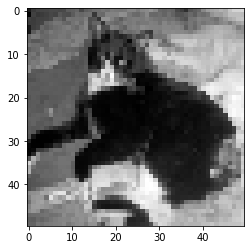

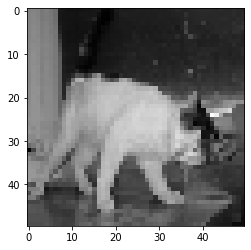

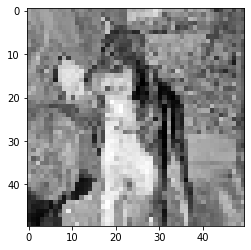

In [34]:
for i in range(3):
    plt.imshow(training_data[i][0], cmap= "gray")
    plt.show()

# Building Model

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(2*2*128, 512) #(Image Size - Kernel Size + 2 * Padding) / Stride + 1) & divide by 2 for each max pooling: (50 - 5 + 2*0)/1 + 1 = 46 | Max pooling: 23 | (23 - 5 + 2*0)/1 + 1 = 19 | Max pooling: 9 , repeat ... eventually get 2. Thus, size is equal to 2 * 2 * 128
        self.fc2 = nn.Linear(512, 2)
    

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        x = x.view(-1, 2*2*128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        

In [41]:
net = Net()
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [42]:
import torch.optim as optim


In [44]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

In [45]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [46]:
VAL_PCT = .1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [54]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(train_y))
print(len(test_X), len(test_y))


22452 22452
2494 2494


In [57]:
BATCH_SIZE = 128
EPOCHS = 1
loss = 0

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    print("EPOCH: " + str(epoch) + " LOSS: " + str(loss))
    
print(loss)
    

100%|██████████| 176/176 [01:22<00:00,  2.12it/s]

EPOCH: 0 LOSS: tensor(0.2252, grad_fn=<MseLossBackward>)
tensor(0.2252, grad_fn=<MseLossBackward>)


In [58]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:03<00:00, 717.33it/s]

Accuracy:  0.649


### Future Works:
Increase number of epochs. \
Display better accuracy measures. \
Include graphs for accuracy. \
Create a more sophisticated model (residual connections, ...)